In [62]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
import optuna
import scipy.stats as stats
import math
import pandas as pd
import seaborn as sns
from collections import defaultdict
from scipy.optimize import brentq
from scipy.stats import sem
from scipy.special import lambertw, wrightomega
import sys

# Data generation

In [63]:
def generate_periodic(upper_bound, lower_bound, n_samples=48, frequencies=2, phases=np.pi / 4, noise_level=0.05):
    frequencies = np.atleast_1d(np.asarray(frequencies))
    phases = np.atleast_1d(np.asarray(phases))

    a = 0.5 * (np.log(upper_bound) - np.log(lower_bound))
    b = 0.5 * (np.log(upper_bound) + np.log(lower_bound))

    samples = np.ones(n_samples)
    for frequency, phase in zip(frequencies, phases):
        angles = np.linspace(0, frequency * 2 * np.pi, n_samples) + phase
        normal_samples = stats.norm.rvs(loc=np.cos(angles), scale=noise_level)
        samples *= np.exp(a * normal_samples + b)
    return np.power(samples, 1. / len(frequencies))

In [64]:
def random_ad_group(id=0, mean_spend=100, mean_cpa=5, mean_samples=24 * 7, mean_freq=1.5, num_freq=2, max_time_offset=24 * 9):
    n_samples = np.inf
    while 1 + n_samples > max_time_offset:
        n_samples = np.random.poisson(mean_samples) + 1

    frequencies = np.random.poisson(mean_freq, num_freq) + 1
    phases = np.random.uniform(0, 2 * np.pi, num_freq)
    offset = np.random.randint(0, max_time_offset - n_samples)
    min_spend, max_spend = tuple(np.sort(np.random.exponential(mean_spend, 2)))
    min_cpa, max_cpa = tuple(np.sort(np.random.exponential(mean_cpa, 2)))

    spends = generate_periodic(min_spend, max_spend, n_samples, frequencies=frequencies, phases=phases)
    ratios = generate_periodic(min_cpa, max_cpa, n_samples, frequencies=frequencies, phases=phases)
    convs = np.asarray(spends / ratios, dtype=int)
    offsets = offset + np.arange(n_samples)
    return pd.DataFrame(dict(offset=offsets, id=id, spend=spends, convs=convs, true_ratio=ratios))

In [65]:
def normalized_ratio(numerator, denominator):
    return numerator / (numerator + denominator)

def generate_ar_features(df, window_size=7):
    norm_ratios = normalized_ratio(df['spend'], df['convs'])
    features = pd.Series(norm_ratios.rolling(window=window_size)) \
        .apply(lambda arr: np.pad(arr, pad_width=(window_size - len(arr), 0)))
    return features

In [66]:
def generate_dataset(n_ad_groups, feat_window=3, **kwargs):
    def add_ar_features(df):
        return df.assign(features=generate_ar_features(df, feat_window))
    
    df = pd.concat([add_ar_features(random_ad_group(i, **kwargs)) for i in range(n_ad_groups)])
    df.sort_values('offset', inplace=True)
    df['offset'] -= df['offset'].min()
    return df

# Models

In [67]:
class QuadraticLossPredictor:
    def __init__(self, lr, reg, dimension):
        self.theta = np.zeros(dimension)
        self.bias = 1
        self.learning_rate = lr
        self.regularization_param = reg
        self.time_step = 1

    def update(self, cost, num_conv, features):
        features = np.asarray(features)
        lr = self.learning_rate / math.sqrt(self.time_step)
        scaling_factor = -cost if num_conv == 0 else self.find_scaling_factor(features, num_conv, cost, lr)
        self.theta = (self.theta - lr * scaling_factor * features)/(1 + lr * self.regularization_param)
        self.bias = (self.bias - lr * scaling_factor)/(1 + lr * self.regularization_param)
        self.time_step += 1

    def predict(self, features):
        dot = np.dot(self.theta, features) + self.bias
        return dot if dot > 0 else 0

    def find_scaling_factor(self, features, num_conv, cost, lr):
        features_norm = 1 + np.sum(features ** 2)
        theta_dot_features = np.dot(self.theta, features) + self.bias
        candidate_one = num_conv * theta_dot_features - cost - lr * cost * self.regularization_param
        candidate_one = candidate_one / (num_conv * lr * features_norm + 1 + lr * self.regularization_param)
        candidate_two = theta_dot_features / (lr * features_norm)
        if candidate_one >= -cost:
            return candidate_one
        elif candidate_two < -cost:
            return candidate_two
        else:
            return -cost 

In [68]:
class ExponentialLossPredictor:
    def __init__(self, lr, reg, dimension):
        self.theta = np.zeros(dimension)
        self.bias = 1
        self.learning_rate = lr
        self.regularization_param = reg
        self.time_step = 1

    def update(self, cost, num_conv, features):
        alpha = num_conv
        beta = cost
        features = np.asarray(features)
        
        lr = self.learning_rate / math.sqrt(self.time_step)
        common_denom = 1 + lr * self.regularization_param

        dual_solution = self.solve_dual(alpha, beta, features, lr, common_denom)
        self.theta = (self.theta - lr * dual_solution * features) / common_denom
        self.bias = (self.bias - lr * dual_solution) / common_denom
        self.time_step += 1

    def predict(self, features):
        dot = np.dot(self.theta, features) + self.bias
        try:
            return math.exp(dot)
        except OverflowError:
            return math.nextafter(sys.float_info.max, 0)

    def solve_dual(self, alpha, beta, features, lr, common_denom):
        if alpha == 0:
            return -beta  # that's the only dual feasible solution

        u = lr * (1 + np.sum(features ** 2)) / common_denom
        v = (np.dot(self.theta, features) + self.bias) / common_denom

        return wrightomega(beta * u + v + np.log(alpha * u)) / u - beta

In [69]:
class ExponentialQuadraticLossPredictor:
    def __init__(self, lr, reg, dimension):
        self.theta = np.zeros(dimension)
        self.bias = 1
        self.learning_rate = lr
        self.regularization_param = reg
        self.time_step = 1

    def update(self, cost, num_conv, features):
        alpha = num_conv
        beta = cost
        features = np.asarray(features)

        lr = self.learning_rate / math.sqrt(self.time_step)
        common_denom = 1 + lr * self.regularization_param

        dual_solution = self.solve_dual(alpha, beta, features, lr, common_denom)
        self.theta = (self.theta - lr * dual_solution * features) / common_denom
        self.bias = (self.bias - lr * dual_solution) / common_denom
        self.time_step += 1

    def predict(self, features):
        dot = np.dot(self.theta, features) + self.bias
        if dot > 0:
            return 1 + dot + 0.5 * dot ** 2
        else:
            return np.exp(dot)

    def solve_dual(self, alpha, beta, features, lr, common_denom):
        if alpha == 0:
            return -beta  # that's the only dual feasible solution

        u = lr * (1 + np.sum(features ** 2)) / common_denom
        v = (np.dot(self.theta, features) + self.bias) / common_denom

        def conj_deriv(s):
            if 0 < s <= 1:
                return math.log(s)
            elif s > 1:
                return s - 1
            else:
                raise RuntimeError("BUG!!!")

        def deriv_neg(s):
            return u * s - v + conj_deriv((s + beta) / alpha)

        lb = 1
        while deriv_neg(-beta + lb) >= 0:
            lb /= 2
        lb = -beta + lb


        ub = 1
        while deriv_neg(ub) <= 0:
            ub *= 2

        return brentq(deriv_neg, lb, ub)

In [70]:
class LinearRegressionPredictor:
    def __init__(self, lr, reg, dimension, inverse):
        self.theta = np.zeros(dimension)
        self.bias = 1
        self.learning_rate = lr
        self.regularization_param = reg
        self.time_step = 1
        self.inverse = inverse

    def update(self, cost, num_conv, features):
        if self.inverse:
            alpha, beta = (cost, num_conv)
        else:
            alpha, beta = (num_conv, cost)
        features = np.asarray(features)
        lr = self.learning_rate / math.sqrt(self.time_step)
        common_denom = 1 + lr * self.regularization_param

        dual_solution = 0 if alpha == 0 else self.solve_dual(alpha, beta, features, lr, common_denom)
        self.theta = (self.theta - lr * dual_solution * features) / common_denom
        self.bias = (self.bias - lr * dual_solution) / common_denom
        self.time_step += 1


    def predict(self, features):
        dot = np.dot(self.theta, features) + self.bias
        if self.inverse:
            return 1 / dot if dot > 0 else 0
        else:
            return dot if dot > 0 else 0

    def solve_dual(self, alpha, beta, features, lr, common_denom):
        u = lr * (1 + np.sum(features ** 2)) / common_denom
        v = (np.dot(self.theta, features) + self.bias) / common_denom

        alpha_beta = alpha * beta
        alpha_sq = alpha ** 2

        first_cand = (alpha_sq * v - alpha_beta) / (alpha_sq * u + 1)
        second_cand = v / u
        if first_cand >= -alpha_beta:
            return first_cand
        else:
            return second_cand

In [71]:
DecayType = Enum('DecayType', ['COST', 'CONV', 'TIME'])

class DecayPredictor:
    def __init__(self, decay_rate, decay_interval, decay_type: DecayType):
        self.decay_rate = decay_rate
        self.decay_type = decay_type
        self.decay_interval = decay_interval
        self.cost = 0
        self.conv = 0
        self.current_interval = None
        self.time_step = 1

    def update(self, cost, num_conv, time):
        self.time_step += 1
        self.cost += cost
        self.conv += num_conv
        self.consider_decay(cost, num_conv, time)

    def consider_decay(self, cost, num_conv, time):
        if self.decay_type == DecayType.COST:
            if self.current_interval is None:
                self.current_interval = 0
            self.current_interval += cost
            if self.current_interval >= self.decay_interval:
                self.decay()
                self.current_interval = 0
        elif self.decay_type == DecayType.CONV:
            if self.current_interval is None:
                self.current_interval = 0
            self.current_interval += num_conv
            if self.current_interval >= self.decay_interval:
                self.decay()
                self.current_interval = 0
        elif self.decay_type == DecayType.TIME:
            if self.current_interval is None:
                self.current_interval = time
            if time - self.current_interval >= self.decay_interval:
                self.decay()
                self.current_interval = time

    def decay(self):
        self.cost = self.cost * self.decay_rate
        self.conv = self.conv * self.decay_rate

    def predict(self):
        if self.conv == 0:
            return 0
        else:
            return self.cost / self.conv


# Test once on one ad group

In [72]:
df = random_ad_group()

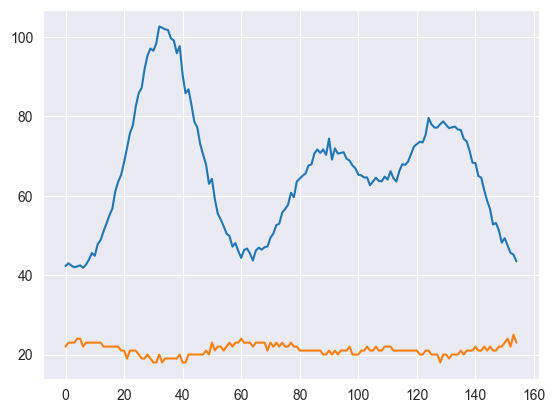

In [73]:
plt.plot(df[['spend', 'convs']].values)
plt.show()

In [74]:
window_size = 5
df = df.assign(features=generate_ar_features(df, window_size=window_size))

In [75]:
def test_predictor(predictor, df):
    progress = dict(prediction=[], actual=[], loss=[], true=[])
    for row in df.itertuples():
        prediction = predictor.predict(row.features)
        actual = math.nextafter(row.spend, math.inf) / math.nextafter(row.convs, math.inf)
        loss = abs(math.log(math.nextafter(prediction, math.inf)) - math.log(math.nextafter(actual, math.inf)))

        progress['prediction'].append(prediction)
        progress['actual'].append(actual)
        progress['true'].append(row.true_ratio)
        progress['loss'].append(loss)

        predictor.update(row.spend, row.convs, row.features)

    return pd.DataFrame(progress), predictor.theta, predictor.bias

In [76]:
results_quad, theta_quad, bias_quad = test_predictor(QuadraticLossPredictor(lr=1, reg=0.000001, dimension=window_size), df)
results_lr, theta_lr, bias_lr = test_predictor(LinearRegressionPredictor(lr=0.05, reg=0.000001, dimension=window_size, inverse=False), df)
results_lr_inv, theta_lr_inv, bias_lr_inv = test_predictor(LinearRegressionPredictor(lr=0.1, reg=0.000001, dimension=window_size, inverse=True), df)
result_exp, theta_exp, bias_exp = test_predictor(ExponentialLossPredictor(lr=10, reg=0.0000000001, dimension=window_size), df)
result_exp_quad, theta_exp_quad, bias_exp_quad = test_predictor(ExponentialQuadraticLossPredictor(lr=10, reg=0.1, dimension=window_size), df)

In [77]:
theta_quad, bias_quad

(array([-0.03347979, -0.01989515, -0.01005027, -0.00996368,  0.44730891]),
 1.6403240438037474)

In [78]:
theta_lr, bias_lr

(array([-0.03348816, -0.01992108, -0.01003125, -0.01100869,  0.44760768]),
 1.6408429744382291)

In [79]:
theta_lr_inv, bias_lr_inv

(array([ 0.00142575,  0.00078771,  0.00071016,  0.00461367, -0.22065843]),
 0.6688269802122228)

In [80]:
theta_exp, bias_exp

(array([-0.00861146, -0.00487665, -0.00255281, -0.01196867, -0.15237552]),
 0.7544787766003229)

In [81]:
theta_exp_quad, bias_exp_quad

(array([0.19241775, 0.19199973, 0.19269885, 0.18891745, 0.19289062]),
 0.2510710886842052)

In [82]:
def mean_se(col):
    mean = col.mean()
    se = sem(col)
    return mean, se

pd.DataFrame.from_records(
    (mean_se(results_quad['loss'][2:]),
     mean_se(results_lr['loss'][2:]),
     mean_se(results_lr_inv['loss'][2:]),
     mean_se(result_exp['loss'][2:]),
     mean_se(result_exp_quad['loss'])), columns=['mean', 'se'], index=[
        'Quadratic', 'Linear Regression', 'Inverse linear regression', 'Exponential', 'Exponential-quadratic'
    ])

,mean,se
Quadratic,0.036962,0.002328
Linear Regression,0.036911,0.002327
Inverse linear regression,0.032184,0.002074
Exponential,0.038299,0.002461
Exponential-quadratic,0.529386,0.019382


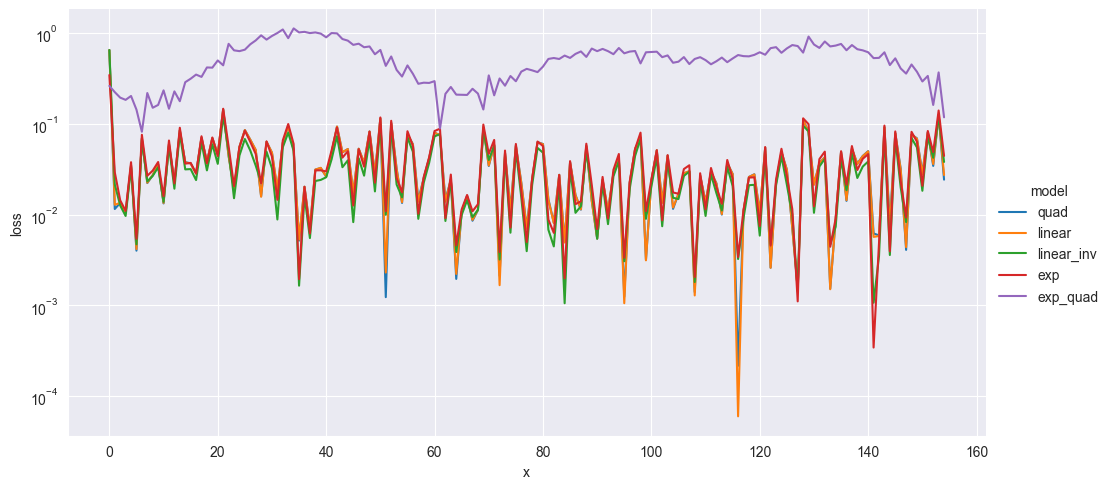

In [83]:
plot_df = pd.concat([
    results_quad.assign(model='quad', x=range(len(df))),
    results_lr.assign(model='linear', x=range(len(df))),
    results_lr_inv.assign(model='linear_inv', x=range(len(df))),
    result_exp.assign(model='exp', x=range(len(df))),
    result_exp_quad.assign(model='exp_quad', x=range(len(df))),
])
sns.relplot(data=plot_df, x='x', y='loss', hue='model', kind='line', aspect=2, height=5)
plt.yscale('log')
plt.show()

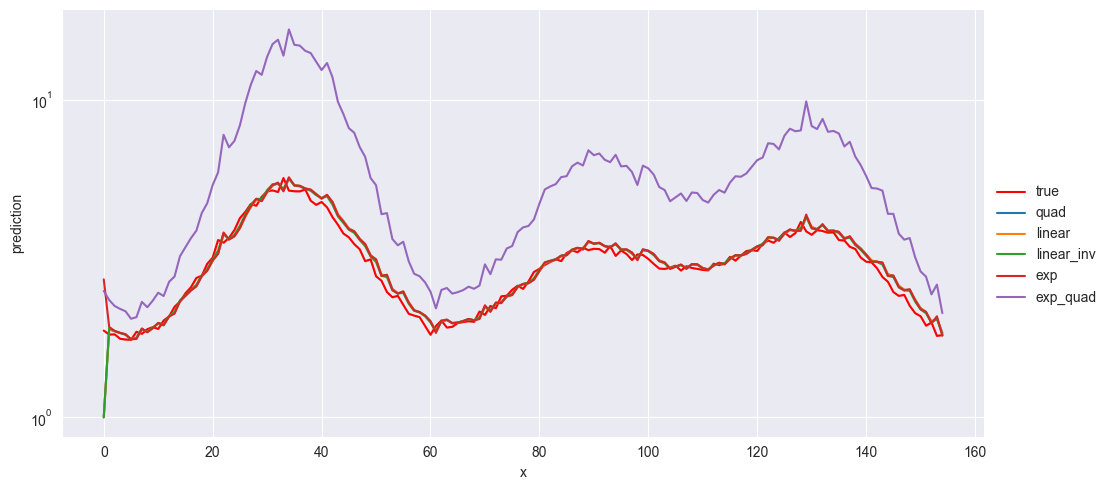

In [84]:
g = sns.FacetGrid(data=plot_df, aspect=2, height=5)
g.map_dataframe(sns.lineplot, x='x', y='true', color='r', label='true')
g.map_dataframe(sns.lineplot, x='x', y='prediction', hue='model')
g.add_legend()
plt.yscale('log')
plt.show()

# Test with tuning on one ad group

In [85]:
df = random_ad_group()
window_size = 4
df = df.assign(features=generate_ar_features(df, window_size=window_size))

In [86]:
def train(predictor_cls, params, df, tail_frac=0.9):
    results, _, _ = test_predictor(predictor_cls(**params), df)
    tail_len = int(len(df) * tail_frac)
    return results['loss'][-tail_len:].mean()

In [87]:
def tune(trial: optuna.Trial, df, predictor_cls, **predictor_kwargs):
    lr = trial.suggest_float('lr', 0.0001, 100, log=True)
    reg = trial.suggest_float('reg', 1e-10, 0.1, log=True)
    return train(predictor_cls, dict(lr=lr, reg=reg, dimension=window_size) | predictor_kwargs, df)

In [88]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [89]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: tune(trial, df, QuadraticLossPredictor), n_trials=200)
study.best_value, study.best_params

(0.05264663312004826, {'lr': 98.71961273921484, 'reg': 0.005056456817424438})

In [90]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: tune(trial, df, ExponentialLossPredictor), n_trials=200)
study.best_value, study.best_params

(0.054644763603412624, {'lr': 99.54765828951331, 'reg': 0.011304430257226725})

In [91]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: tune(trial, df, LinearRegressionPredictor, inverse=False), n_trials=200)
study.best_value, study.best_params

(0.0526323161321395, {'lr': 95.78656000724138, 'reg': 0.005086413774840848})

In [92]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: tune(trial, df, LinearRegressionPredictor, inverse=True), n_trials=200)
study.best_value, study.best_params

(0.05159252925575206, {'lr': 99.90906009046004, 'reg': 1.0010968481054251e-10})

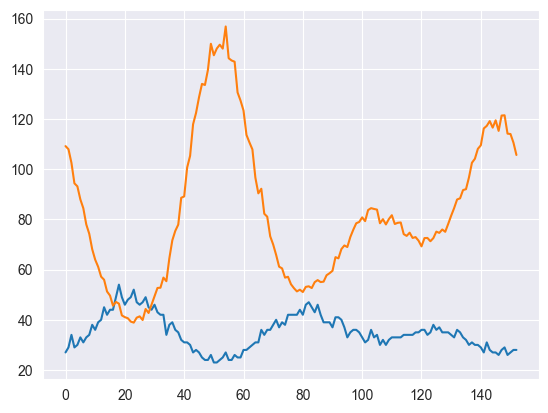

In [93]:
plt.plot(df[['convs', 'spend']].values)

# Test on a dataset

In [94]:
window_size = 4
n_tune = 1000
n_test = 20000
ds = generate_dataset(n_tune, feat_window=window_size, mean_spend=100, mean_cpa=5)
ds

,offset,id,spend,convs,true_ratio,features
0,0,55,58.295533,1053,0.055315,"[0.0, 0.0, 0.0, 0.05245727317337564]"
0,0,201,68.903958,28,2.416136,"[0.0, 0.0, 0.0, 0.7110541152285517]"
0,0,607,63.178155,8,7.465083,"[0.0, 0.0, 0.0, 0.8876059649671735]"
0,0,369,34.052326,3,10.076046,"[0.0, 0.0, 0.0, 0.9190334234750858]"
0,0,143,6.842154,2,2.909169,"[0.0, 0.0, 0.0, 0.773810759956686]"
...,...,...,...,...,...,...
161,214,176,41.159670,5,8.092721,"[0.8940459757115166, 0.8955661438281383, 0.887..."
182,214,687,98.561280,22,4.387731,"[0.8212638189915896, 0.8185885010539617, 0.818..."
182,214,923,15.191375,78,0.194176,"[0.14737837350001914, 0.14550229038737872, 0.1..."
162,214,435,64.272511,11,5.394047,"[0.8576741050651234, 0.8583072981439359, 0.855..."


In [95]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
common_optuna_args = dict(n_trials=100, show_progress_bar=True)

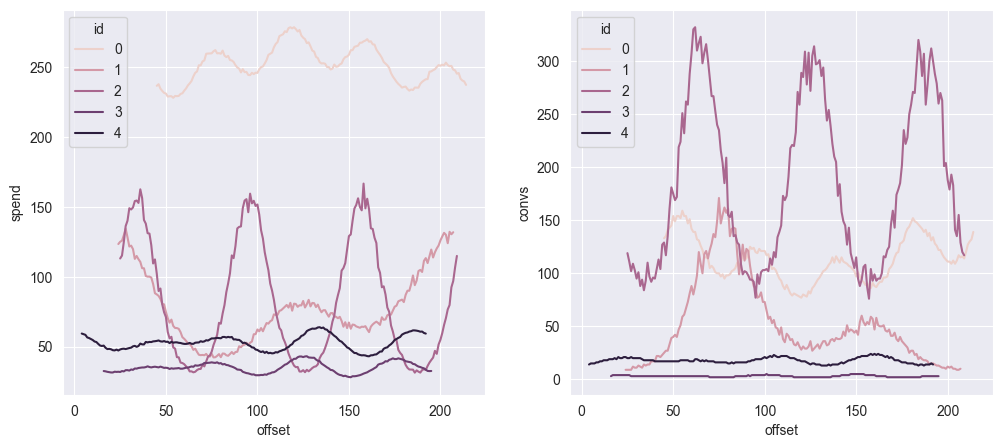

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=ds[ds['id'].isin(range(5))],
             x='offset', y='spend', hue='id', ax=ax1)
sns.lineplot(data=ds[ds['id'].isin(range(5))],
             x='offset', y='convs', hue='id', ax=ax2)
plt.show()

In [97]:
def run_on_ds(ds, predictor_cls, params, decay=False, stderr=False):
    predictors = defaultdict(lambda: predictor_cls(**params))
    samples = []
    for row in ds.itertuples():
        predictor = predictors[row.id]
        if decay:
            prediction = predictor.predict()
        else:
            prediction = predictor.predict(row.features)

        prediction = math.nextafter(prediction, math.inf)
        spend = math.nextafter(row.spend, math.inf)
        convs = math.nextafter(row.convs, math.inf)
        loss = abs(math.log(prediction) - math.log(spend) + math.log(convs))

        if predictor.time_step > 2:
            samples.append([row.spend, loss])

        if decay:
            predictor.update(row.spend, row.convs, row.offset)
        else:
            predictor.update(row.spend, row.convs, row.features)

    samples = np.array(samples)
    weights = samples[:, 0]
    losses = samples[:, 1]
    n_samples = len(samples)

    mean_loss = np.sum(losses * weights) / np.sum(weights)
    if not stderr:
        return mean_loss
    else: # use the Gatz-Smith estimator: https://www.sciencedirect.com/science/article/abs/pii/135223109400210C
        mean_weight = np.mean(weights)
        stderr_squared_est = (
            n_samples 
            * 
            np.sum((weights ** 2) * (losses - mean_loss) ** 2) 
            / 
            ((n_samples - 1) * (n_samples * mean_weight) ** 2)
        )
        return mean_loss, np.sqrt(stderr_squared_est)

In [98]:
def tune_ds_decay(trial: optuna.Trial, ds, predictor_cls, decay=False, **predictor_kwargs):
    decay_rate = trial.suggest_float('decay_rate', 0, 1)
    decay_interval = trial.suggest_float('decay_interval', 1, 1000, log=True)
    params = dict(decay_rate=decay_rate, decay_interval=decay_interval) | predictor_kwargs
    loss, stderr = run_on_ds(ds, predictor_cls, params, decay=decay, stderr=True)
    trial.set_user_attr('stderr', stderr)
    return loss

In [99]:
def tune_ds(trial: optuna.Trial, ds, predictor_cls, **predictor_kwargs):
    lr = trial.suggest_float('lr', 1e-8, 100, log=True)
    reg = trial.suggest_float('reg', 1e-10, 100, log=True)
    params = dict(lr=lr, reg=reg) | predictor_kwargs
    loss, stderr = run_on_ds(ds, predictor_cls, params, stderr=True)
    trial.set_user_attr('stderr', stderr)
    return loss    

## Train and tune on the generated dataset

In [100]:
study_exp = optuna.create_study(direction='minimize')
study_exp.optimize(lambda trial: tune_ds(trial, ds, ExponentialLossPredictor, dimension=window_size), **common_optuna_args)
study_exp.best_value, study_exp.best_params, study_exp.best_trial.user_attrs

  0%|          | 0/100 [00:00<?, ?it/s]

(0.192604478279596,
 {'lr': 93.38596439864597, 'reg': 0.0016789500057147453},
 {'stderr': 0.0076859948801751435})

In [101]:
study_decay_cost = optuna.create_study(direction='minimize')
study_decay_cost.optimize(lambda trial: tune_ds_decay(trial, ds, DecayPredictor, decay=True, decay_type=DecayType.COST), **common_optuna_args)
study_decay_cost.best_value, study_decay_cost.best_params, study_decay_cost.best_trial.user_attrs

  0%|          | 0/100 [00:00<?, ?it/s]

(0.6129792710665831,
 {'decay_rate': 7.945887994846405e-05, 'decay_interval': 2.0422648466151934},
 {'stderr': 0.015928748439660932})

In [102]:
study_decay_conv = optuna.create_study(direction='minimize')
study_decay_conv.optimize(lambda trial: tune_ds_decay(trial, ds, DecayPredictor, decay=True, decay_type=DecayType.CONV), **common_optuna_args)
study_decay_conv.best_value, study_decay_conv.best_params, study_decay_conv.best_trial.user_attrs

  0%|          | 0/100 [00:00<?, ?it/s]

(0.6737020610718839,
 {'decay_rate': 0.0013548310165157687, 'decay_interval': 1.4296046211264641},
 {'stderr': 0.01757196088550538})

In [103]:
study_decay_time = optuna.create_study(direction='minimize')
study_decay_time.optimize(lambda trial: tune_ds_decay(trial, ds, DecayPredictor, decay=True, decay_type=DecayType.TIME), **common_optuna_args)
study_decay_time.best_value, study_decay_time.best_params, study_decay_time.best_trial.user_attrs

  0%|          | 0/100 [00:00<?, ?it/s]

(0.6468755014734293,
 {'decay_rate': 0.00011239487367700621, 'decay_interval': 1.2259644575737885},
 {'stderr': 0.016700339586227447})

In [104]:
study_quad = optuna.create_study(direction='minimize')
study_quad.optimize(lambda trial: tune_ds(trial, ds, QuadraticLossPredictor, dimension=window_size), **common_optuna_args)
study_quad.best_value, study_quad.best_params, study_quad.best_trial.user_attrs

  0%|          | 0/100 [00:00<?, ?it/s]

(0.5838905913688398,
 {'lr': 95.9403361295109, 'reg': 0.009751591121062888},
 {'stderr': 0.01523097681551623})

In [105]:
study_lr = optuna.create_study(direction='minimize')
study_lr.optimize(lambda trial: tune_ds(trial, ds, LinearRegressionPredictor, dimension=window_size, inverse=False), **common_optuna_args)
study_lr.best_value, study_lr.best_params, study_lr.best_trial.user_attrs

  0%|          | 0/100 [00:00<?, ?it/s]

(0.5877400530012162,
 {'lr': 5.3800974179365655, 'reg': 0.030004242299896976},
 {'stderr': 0.015339284024398481})

In [106]:
study_lr_inv = optuna.create_study(direction='minimize')
study_lr_inv.optimize(lambda trial: tune_ds(trial, ds, LinearRegressionPredictor, dimension=window_size, inverse=True), **common_optuna_args)
study_lr_inv.best_value, study_lr_inv.best_params, study_lr_inv.best_trial.user_attrs

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/kk/39k_xf5j1_9cdr9kjf3y5s940000gp/T/ipykernel_49377/4118927764.py:28: RuntimeWarning: overflow encountered in scalar divide
  return 1 / dot if dot > 0 else 0
/var/folders/kk/39k_xf5j1_9cdr9kjf3y5s940000gp/T/ipykernel_49377/837616443.py:37: RuntimeWarning: invalid value encountered in subtract
  np.sum((weights ** 2) * (losses - mean_loss) ** 2)


(0.5892942689853642,
 {'lr': 0.00907524492629277, 'reg': 13.722909988984888},
 {'stderr': 0.015181708830362578})

## Test on an unseen dataset with similar distribution

In [107]:
# simulate 20 days.
test_ds = generate_dataset(n_test, feat_window=window_size, max_time_offset=24 * 20)
test_ds['offset'].max()

478

In [108]:
decay_cost_tuned_loss = run_on_ds(test_ds, DecayPredictor, study_decay_cost.best_params | dict(decay_type=DecayType.COST), decay=True, stderr=True)
decay_cost_tuned_loss

/var/folders/kk/39k_xf5j1_9cdr9kjf3y5s940000gp/T/ipykernel_49377/837616443.py:37: RuntimeWarning: invalid value encountered in subtract
  np.sum((weights ** 2) * (losses - mean_loss) ** 2)


(inf, nan)

In [109]:
decay_conv_tuned_loss = run_on_ds(test_ds, DecayPredictor, study_decay_conv.best_params | dict(decay_type=DecayType.CONV), decay=True, stderr=True)
decay_conv_tuned_loss

(0.8210250680271762, 0.004630196639093699)

In [110]:
decay_time_tuned_loss = run_on_ds(test_ds, DecayPredictor, study_decay_time.best_params | dict(decay_type=DecayType.TIME), decay=True, stderr=True)
decay_time_tuned_loss

/var/folders/kk/39k_xf5j1_9cdr9kjf3y5s940000gp/T/ipykernel_49377/837616443.py:37: RuntimeWarning: invalid value encountered in subtract
  np.sum((weights ** 2) * (losses - mean_loss) ** 2)


(inf, nan)

In [111]:
quad_tuned_loss = run_on_ds(test_ds, QuadraticLossPredictor, study_quad.best_params | dict(dimension=window_size), stderr=True)
quad_tuned_loss

(0.6260195990267348, 0.003305147067636906)

In [112]:
exp_tuned_loss = run_on_ds(test_ds, ExponentialLossPredictor, study_quad.best_params | dict(dimension=window_size), stderr=True)
exp_tuned_loss

(0.18560476968454792, 0.0015102648166571693)

In [113]:
lr_tuned_loss = run_on_ds(test_ds, LinearRegressionPredictor, study_lr.best_params | dict(dimension=window_size, inverse=False), stderr=True)
lr_tuned_loss

(0.6307077125565461, 0.00333324042995373)

In [114]:
lr_inv_tuned_loss = run_on_ds(test_ds, LinearRegressionPredictor, study_lr_inv.best_params | dict(dimension=window_size, inverse=True), stderr=True)
lr_inv_tuned_loss

(0.651508305921259, 0.003681531844087667)

## Test on an unseen dataset with a slightly different spend / CPA distribution

In [115]:
# simulate 20 days of a slightly different distribution
test_ds_shifted = generate_dataset(n_test, feat_window=window_size, mean_cpa=6, mean_spend=90, max_time_offset=24 * 20)
test_ds_shifted['true_ratio'].mean()

5.035080856455825

In [116]:
decay_cost_tuned_loss = run_on_ds(test_ds_shifted, DecayPredictor, study_decay_cost.best_params | dict(decay_type=DecayType.COST), decay=True, stderr=True)
decay_cost_tuned_loss

/var/folders/kk/39k_xf5j1_9cdr9kjf3y5s940000gp/T/ipykernel_49377/837616443.py:37: RuntimeWarning: invalid value encountered in subtract
  np.sum((weights ** 2) * (losses - mean_loss) ** 2)


(inf, nan)

In [117]:
decay_conv_tuned_loss = run_on_ds(test_ds_shifted, DecayPredictor, study_decay_conv.best_params | dict(decay_type=DecayType.CONV), decay=True, stderr=True)
decay_conv_tuned_loss

(1.64782420192885, 0.0077574369057917475)

In [118]:
decay_time_tuned_loss = run_on_ds(test_ds_shifted, DecayPredictor, study_decay_time.best_params | dict(decay_type=DecayType.TIME), decay=True, stderr=True)
decay_time_tuned_loss

(1.5871462933228313, 0.007564528589599056)

In [119]:
quad_tuned_loss = run_on_ds(test_ds_shifted, QuadraticLossPredictor, study_quad.best_params | dict(dimension=window_size), stderr=True)
quad_tuned_loss

(1.2217210686127582, 0.005497630757565396)

In [120]:
exp_tuned_loss = run_on_ds(test_ds_shifted, ExponentialLossPredictor, study_quad.best_params | dict(dimension=window_size), stderr=True)
exp_tuned_loss

(0.31478883712524053, 0.002541894499206981)

In [121]:
lr_tuned_loss = run_on_ds(test_ds_shifted, LinearRegressionPredictor, study_lr.best_params | dict(dimension=window_size, inverse=False), stderr=True)
lr_tuned_loss

(1.2309284200765558, 0.005544933873724837)

In [122]:
lr_inv_tuned_loss = run_on_ds(test_ds_shifted, LinearRegressionPredictor, study_lr_inv.best_params | dict(dimension=window_size, inverse=True), stderr=True)
lr_inv_tuned_loss

(1.3047335422522761, 0.006401602306734897)